In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from collections import defaultdict 

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
def parse_accs(fname):
    f_string = ''
    with open(fname, 'r') as f:
        for line in f.readlines():
            f_string += (f' {line}')

    perfs = f_string.split('[random_search]')
    perfs = list(filter(lambda s: 'conf=' in s, perfs))
    perf_dict = defaultdict(list)
    for p in perfs:
        s = p.strip().split(',')
        s = [item.strip() for item in s]
        conf = s[0].replace('conf=', '')
        seed = int(s[1].replace('seed=', ''))
        acc = float(s[2].replace('acc=', ''))
        perf_dict[conf].append(acc)

    means = []
    maxs = []
    mins = []
    stds = []
    points = []
    confs = []
    for k in perf_dict.keys():
        means.append(np.mean(perf_dict[k]))
        maxs.append(np.max(perf_dict[k]))
        mins.append(np.min(perf_dict[k]))
        stds.append(np.std(perf_dict[k]))
        points.append(perf_dict[k])
        confs.append(k)

    return means, maxs, mins, stds, points, confs
    
means, maxs, mins, stds, points, confs = parse_accs('results/random_search.log')

In [3]:
points[np.argmax(means)]

[0.3821, 0.4397, 0.4321]

In [4]:
h = confs[np.argmax(means)]
h

'[5.92212138e-02 1.11815863e-01 1.28464862e-01 8.48805478e-02\n  4.19379279e-04 4.04951095e-02 2.02454160e-02 5.72815361e-02\n  4.97176072e-01]'

In [5]:
np.max(means)

0.41796666666666665

In [6]:
len(means)

253

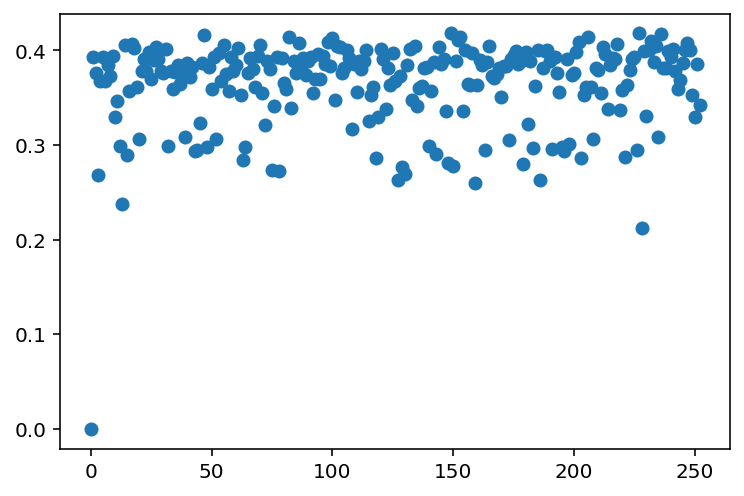

In [7]:
plt.scatter(np.arange(len(means)), means)


In [8]:
rs = []
for i in range(len(means)):
    rs.append(np.max(means[:i+1]))
rs = np.array(rs)

In [9]:
max_stds = []
for i in range(len(means)):
    max_stds.append(maxs[np.argmax(means[:i+1])])
max_stds = np.array(max_stds)

In [10]:
min_stds = []
for i in range(len(means)):
    min_stds.append(mins[np.argmax(means[:i+1])])
min_stds = np.array(min_stds)

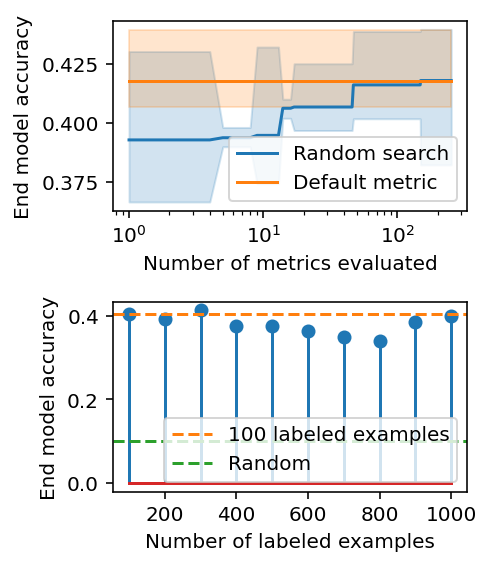

In [20]:

fig, ax = plt.subplots(2, 1, figsize=(3.5, 4))

ax[0].plot(np.arange(1, len(means)), rs[1:], color='C0', label='Random search')
ax[0].fill_between(np.arange(1, len(means)), 
    min_stds[1:], 
    max_stds[1:],
    color='C0', alpha=0.2)

ax[0].set_xlabel('Number of metrics evaluated')
ax[0].set_ylabel('End model accuracy')
#plt.title('Random search for metric combinations')
defaults = [0.4068, 0.4393, 0.4066]
ax[0].plot(np.arange(1, len(means)), np.ones_like(means[1:]) * np.mean(defaults), 
    color='C1', label='Default metric')
ax[0].fill_between(np.arange(1, len(means)), 
    np.min(defaults), 
    np.max(defaults),
    color='C1', alpha=0.2)

ax[0].set_xscale('log')
ax[0].legend(frameon=True, loc='lower right')
#plt.savefig('random_search.pdf', bbox_inches='tight')
#plt.show()



def parse_accs(fname):
    fin_acc = 0
    with open(fname, 'r') as f:
        for line in f.readlines():
            if 'end model (LeNet) test acc: ' in line:
                fin_acc = float(line.split()[-1])
    return fin_acc


seed = 0

get_acc_npoints = lambda n: parse_accs(
    f'results/mnist/snuba_nlabels/n_labeled_points_{n}/res_seed{seed}.log')

nlabels = np.arange(100, 1100, 100)
npoints = [get_acc_npoints(n) for n in nlabels]

npoints[0] = 0.4037


(markerline, stemlines, baseline) = plt.stem(nlabels, npoints)
#plt.setp(baseline, visible=False)
ax[1].axhline(
    npoints[0], 
    linestyle='--', color='C1', label=f'100 labeled examples')
ax[1].axhline(
    0.1, 
    linestyle='--', color='C2', label=f'Random')

ax[1].set_xticks(nlabels[1::2])
ax[1].set_ylabel('End model accuracy')
ax[1].set_xlabel('Number of labeled examples')

ax[1].legend(frameon=True, loc='lower right')

plt.tight_layout()
plt.savefig('neurips/snuba_ablation_1.pdf', bbox_inches='tight')
plt.show()

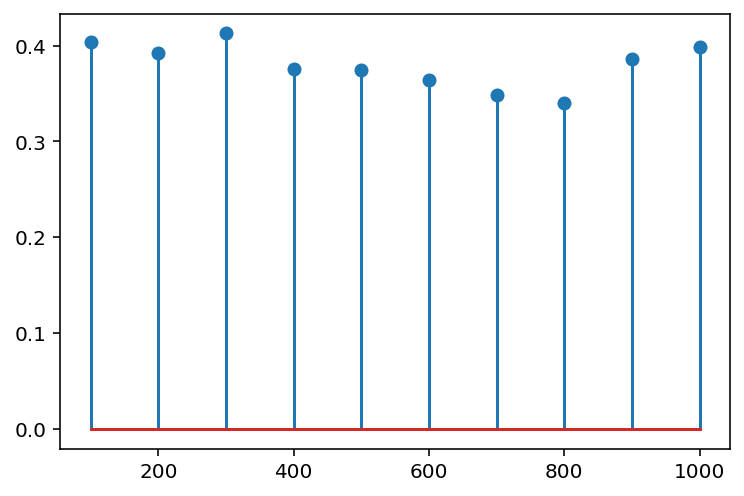